<a href="https://colab.research.google.com/github/mayhd3/NSF-REU-2021/blob/main/AMIvisualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd

if not os.path.exists('SM-30.csv'):
  !gdown --id 1UnP8x_WQ-Aroq8Rz4C1NUSEG9Iul1y7r

sm30 = pd.read_csv('SM-30.csv', header=None)

print(sm30)

        0         1          2   ...          48          49          50
0        1  20160101     Friday  ...   51.175717  143.252283  137.462967
1        1  20160102   Saturday  ...   69.247467   34.006950   13.018783
2        1  20160103     Sunday  ...   87.413983   34.309583    8.045783
3        1  20160104     Monday  ...   57.762917   59.193917   84.350667
4        1  20160105    Tuesday  ...   99.809000   37.494800   62.593817
...    ...       ...        ...  ...         ...         ...         ...
39781  114  20161210   Saturday  ...  103.174867  105.520250   99.261717
39782  114  20161211     Sunday  ...   78.534017   55.942400   61.001317
39783  114  20161212     Monday  ...   94.071350   39.962617   71.267533
39784  114  20161213    Tuesday  ...  114.110617   71.144167   66.459417
39785  114  20161214  Wednesday  ...   80.857933   60.401817   68.659183

[39786 rows x 51 columns]


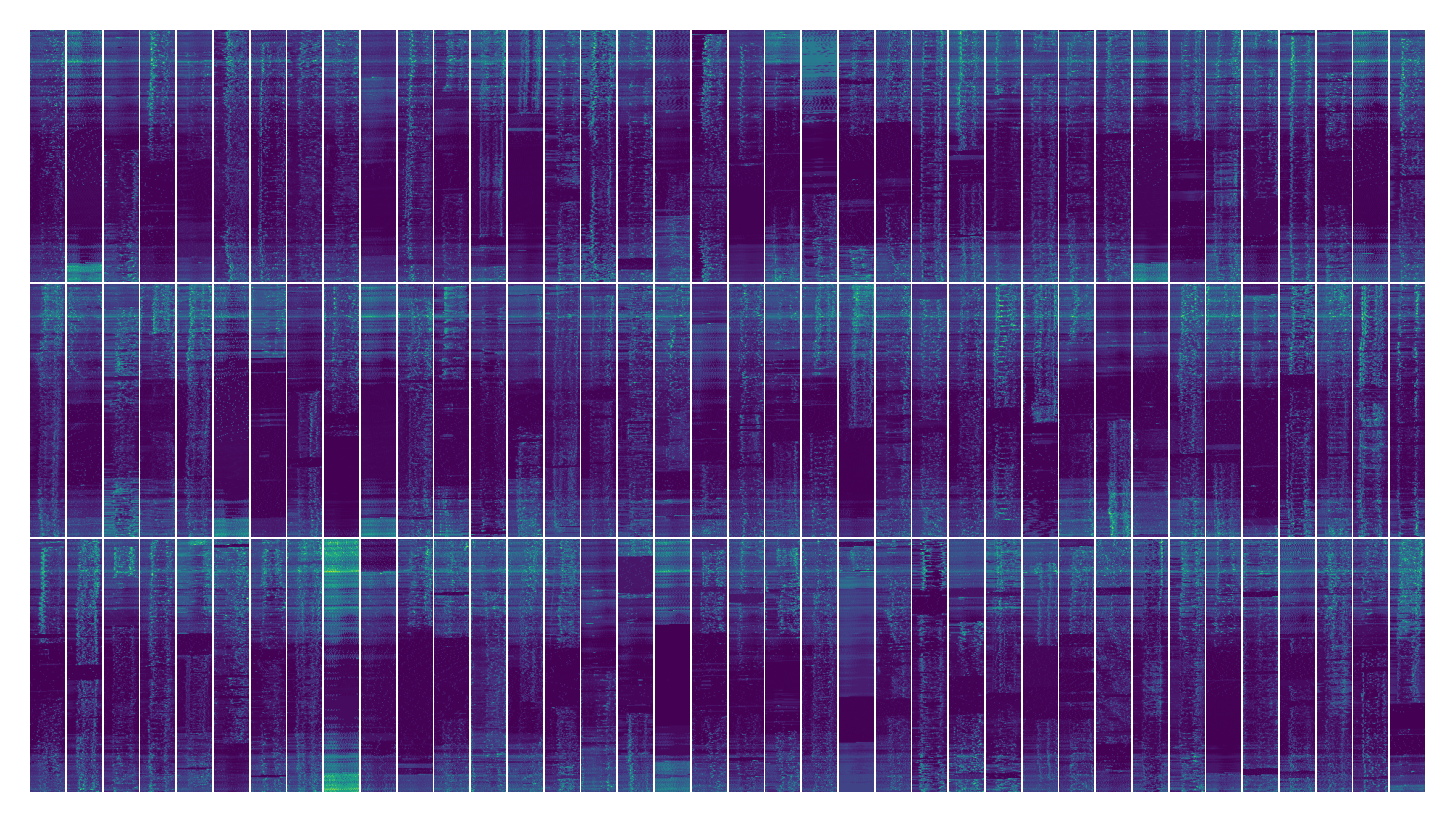

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

meters = np.split(
    sm30.iloc[:,3:].to_numpy(),
    sm30[0].diff()[1:].to_numpy().nonzero()[0] + 1
)

def heatmap(data):
  ig = ImageGrid(plt.gcf(), 111, nrows_ncols=(3, 38), axes_pad=2/300, direction='column')

  for ax,im in zip(ig,data):
    ax.set_axis_off()
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    ax.imshow(im)

plt.figure(dpi=300)
heatmap(meters)

In [3]:
import ipywidgets as ipw
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.colors as mcolors
import random as rng

out1 = ipw.Output()

def plot_with_acf(out, data, index):
  colors = list(mcolors.TABLEAU_COLORS.values())
  color = colors[index%len(colors)]

  if 0 <= index < len(data):
    flat = data[index].flatten()

    out.clear_output()
    with out:
      fig1 = plt.figure(dpi=100)
      plt.title("Meter " + str(index))
      plt.plot(flat, c=color)

      fig2 = plt.figure(dpi=100)
      plot_acf(flat, ax=plt.gca(), lags=np.arange(len(flat))[::500], c=color)

      plt.show()
      return fig1, fig2

it1 = ipw.IntText(
  value=0,
  description='Meter to plot:',
  style={'description_width': 'initial'}
)

it1.observe(lambda event: plot_with_acf(out1, meters, event['new']), names='value')
plot_with_acf(out1, meters, it1.value)

display(it1, out1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


IntText(value=0, description='Meter to plot:', style=DescriptionStyle(description_width='initial'))

Output()

In [4]:
out3 = ipw.Output()

for index in range(len(meters)):
  if not os.path.exists('acf/'):
    os.mkdir('acf/')
  path1, path2 = 'acf/'+str(index)+'.png', 'acf/'+str(index)+'_acf.png'
  exists1, exists2 = os.path.exists(path1), os.path.exists(path2)
  if not exists1 or not exists2:
    fig1, fig2 = plot_with_acf(out3, meters, index)
    if not exists1:
      fig1.savefig(path1)
    if not exists2:
      fig2.savefig(path2)

if not os.path.exists('acf.zip'):
  !zip -r acf.zip acf/

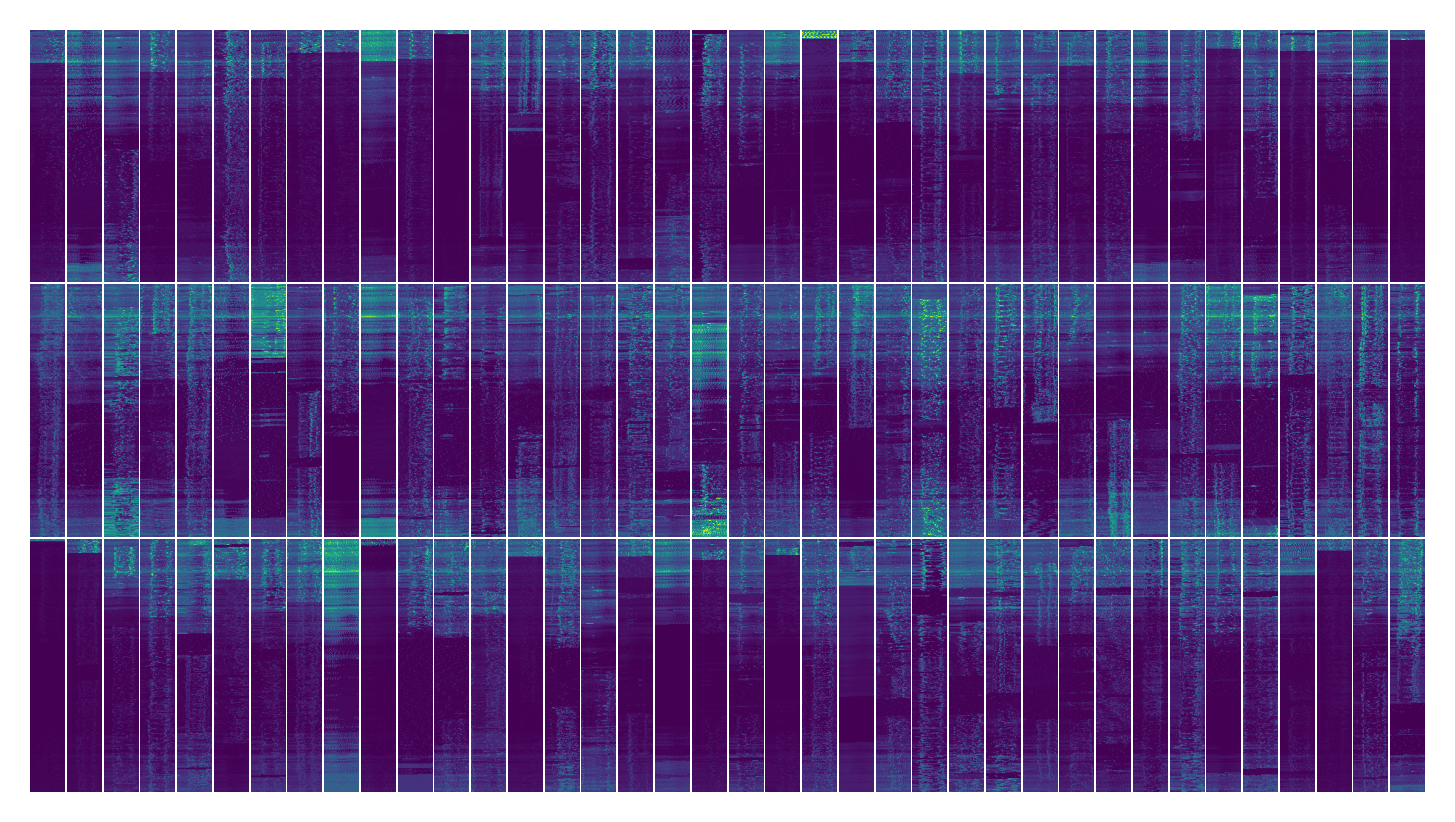

In [5]:
from copy import deepcopy

# simulate energy theft by scaling samples down, clipping them to a max, or both
fakes = deepcopy(meters)

# each sample will have a different starting date
starts = np.linspace(0,1,num=len(fakes),endpoint=False)
np.random.shuffle(starts)

for i in range(len(fakes)):
  # theft starts at most half way through the year
  start = int(starts[i] * (len(fakes[i])-1)/2)

  if (i%3) != 1:
    for j in range(start,len(fakes[i])):
      fakes[i][j] *= starts[i]

  if (i%3) != 0:
    # clip max to somewhere between the first and third quartile
    min, max = np.amin(fakes[i][start:]), np.amax(fakes[i][start:])
    lerp = starts[(i+1)%len(starts)]
    clip = (max+min)*.5 + (max-min)*.25*(lerp-.5)
    for j in range(start,len(fakes[i])):
      fakes[i][j] = np.clip(fakes[i][j],0,clip) 

plt.figure(dpi=300)
heatmap(fakes)

In [6]:
out2 = ipw.Output()

plot_with_acf(out2, fakes, 0)

it2 = ipw.IntText(
  value=0,
  description='Fake meter to plot:',
  style={'description_width': 'initial'}
)
it2.observe(lambda event: plot_with_acf(out2, fakes, event['new']), names='value')
plot_with_acf(out2, fakes, it2.value)

display(it2, out2)

IntText(value=0, description='Fake meter to plot:', style=DescriptionStyle(description_width='initial'))

Output()

In [7]:

# sanity check, fake data shows lower power consumption than the real data
assert(np.less_equal(fakes,meters).all())

# make a similar dataframe with the fake data
sm30f = pd.DataFrame(np.column_stack((sm30[range(3)], np.concatenate(fakes))))

# shuffle and combine both dataframes to make our training and testing datasets
full = pd.concat((
    sm30.shift(axis='columns', fill_value=True).sample(frac=1).reset_index(drop=True),
    sm30f.shift(axis='columns', fill_value=False).sample(frac=1).reset_index(drop=True)
)).sort_index().reset_index(drop=True)

print(full)

          0    1         2          3   ...        47       48        49        50
0       True    7  20161121     Monday  ...   70.5024  47.6571   69.6222   58.3172
1      False   78  20161102  Wednesday  ...   12.4021  13.0083    7.1907   8.03471
2      False   60  20161017     Monday  ...   6.26247  30.5594  0.952348  0.326761
3       True    6  20160701     Friday  ...  0.426233  1.27455   3.19727  0.601383
4       True   22  20160826     Friday  ...   13.6726  24.7554   23.8201   9.92128
...      ...  ...       ...        ...  ...       ...      ...       ...       ...
79567   True  101  20160916     Friday  ...  0.410433  3.51768  0.564117   0.18995
79568  False   90  20160701     Friday  ...   6.94572  8.16998   61.6429   3.35703
79569   True   37  20160627     Monday  ...   0.40225  3.00382   2.40782   17.6436
79570   True   51  20160814     Sunday  ...    4.0514  4.01865   3.99527   3.99572
79571  False   63  20161026  Wednesday  ...   5.58456   4.9437   8.62092   6.69494

[79